# [Text classification with an RNN](https://www.tensorflow.org/beta/tutorials/text/text_classification_rnn)

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta-1
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

Import `matplotlib` and create a helper function to plot graphs:

In [0]:
def plot_graphs(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()

## Setup input pipeline

The IMDB large movie review datasetset is a *binary classification* dataset - all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). The dataset comes with an built-in subword tokenizer.

In [0]:
dataset, info = tfds.load(
    'imdb_reviews/subwords8k', 
    with_info=True,
    as_supervised=True,
)
train_dataset, test_dataset = dataset['train'], dataset['test']

As this is a subwords tokenizer, it can be passed any string and the tokenizer will tokenize it.

In [0]:
tokenizer = info.features['text'].encoder

In [5]:
print(f'Vocabulary size: {tokenizer.vocab_size}')

Vocabulary size: 8185


In [6]:
sample_string = 'TensorFlow is cool.'

tokenized_string = tokenizer.encode(sample_string)
print(f'Tokenized string is {tokenized_string}')

original_string = tokenizer.decode(tokenized_string)
print(f'The original string: {original_string}')

assert original_string == sample_string

Tokenized string is [6307, 2327, 4043, 4265, 9, 2724, 7975]
The original string: TensorFlow is cool.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [7]:
for ts in tokenized_string:
    print(f'{ts} ----> {tokenizer.decode([ts])}')

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
4265 ----> ow 
9 ----> is 
2724 ----> cool
7975 ----> .


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input - and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compile the Keras model to configure the training process:

In [0]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Train the model

In [12]:
history = model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset,
)

Epoch 1/10


W0621 07:38:10.001519 139658977994624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


391/391 [==============================] - 300s 767ms/step - loss: 0.7127 - accuracy: 0.5326 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 126s 321ms/step - loss: 0.5574 - accuracy: 0.7245 - val_loss: 0.5380 - val_accuracy: 0.7350
Epoch 3/10
391/391 [==============================] - 104s 266ms/step - loss: 0.3955 - accuracy: 0.8365 - val_loss: 0.4725 - val_accuracy: 0.8119
Epoch 4/10
391/391 [==============================] - 90s 231ms/step - loss: 0.3157 - accuracy: 0.8765 - val_loss: 0.5973 - val_accuracy: 0.7844
Epoch 5/10
391/391 [==============================] - 88s 225ms/step - loss: 0.2659 - accuracy: 0.9002 - val_loss: 0.4401 - val_accuracy: 0.8408
Epoch 6/10
391/391 [==============================] - 87s 221ms/step - loss: 0.2147 - accuracy: 0.9204 - val_loss: 0.4404 - val_accuracy: 0.8371
Epoch 7/10
391/391 [==============================] - 86s 220ms/step - loss: 0.1803 - accuracy: 0.9346 - val_loss: 0.4835 - val_ac

In [13]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

    391/Unknown - 25s 64ms/step - loss: 0.6328 - accuracy: 0.8130Test Loss: 0.6327809540512007
Test Accuracy: 0.813040018081665


The above model does not mask the padding applied to the sequences. This can lead to skewness if we train on padded sequences and test on un-padded sequences. Ideally the model would learn to ignore the padding, but as you can see below it does have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [0]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [0]:
def sample_predict(sentence, pad):
    tokenized_sample_pred_text = tokenizer.encode(sample_pred_text)
    
    if pad:
        tokenized_sample_pred_text = pad_to_size(tokenized_sample_pred_text, 64)
    
    predictions = model.predict(tf.expand_dims(tokenized_sample_pred_text, 0))
    
    return (predictions)

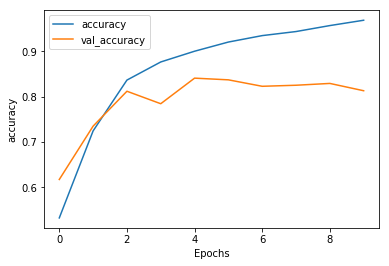

In [16]:
plot_graphs(history, 'accuracy')

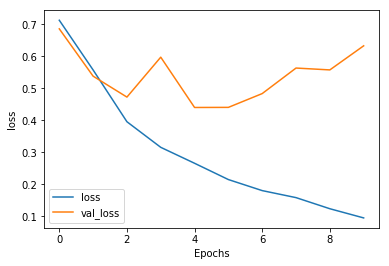

In [17]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

- Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
- Return only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`).

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [15]:
history = model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset,
)

391/391 [==============================] - 517s 1s/step - loss: 0.5948 - accuracy: 0.6642 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 218s 558ms/step - loss: 0.4107 - accuracy: 0.8235 - val_loss: 0.5001 - val_accuracy: 0.7808
Epoch 3/10
391/391 [==============================] - 170s 435ms/step - loss: 0.3265 - accuracy: 0.8699 - val_loss: 0.3932 - val_accuracy: 0.8434
Epoch 4/10
391/391 [==============================] - 152s 389ms/step - loss: 0.2363 - accuracy: 0.9100 - val_loss: 0.4158 - val_accuracy: 0.8408
Epoch 5/10
391/391 [==============================] - 154s 393ms/step - loss: 0.1832 - accuracy: 0.9352 - val_loss: 0.4570 - val_accuracy: 0.8117
Epoch 6/10
391/391 [==============================] - 141s 361ms/step - loss: 0.2225 - accuracy: 0.9137 - val_loss: 0.5450 - val_accuracy: 0.7348
Epoch 7/10
391/391 [==============================] - 141s 361ms/step - loss: 0.4198 - accuracy: 0.8166 - val_loss: 0.5152 - val_a

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

    391/Unknown - 40s 102ms/step - loss: 0.7639 - accuracy: 0.8330

In [17]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

Test Loss: 0.7639284576753826
Test Accuracy: 0.8330399990081787


In [19]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')

predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.00030705]]


In [20]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')

predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.00070012]]


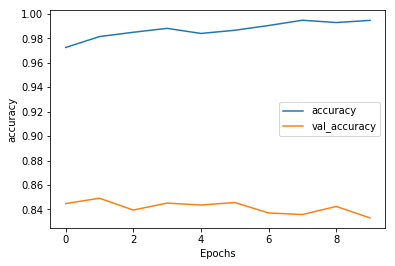

In [21]:
plot_graphs(history, 'accuracy')

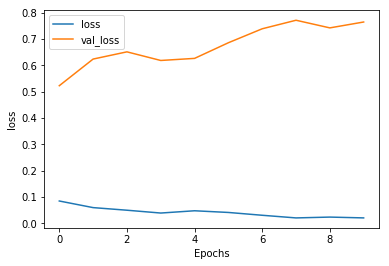

In [22]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).